In [1]:
%load_ext autoreload
%autoreload 2
# You can load your python module as this:
import Functions

In [2]:
import numpy as np
import sympy as sm
import pandas as pd
from scipy import interpolate
from scipy import optimize
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [3]:
from bokeh.io import output_notebook,show, push_notebook
from bokeh.layouts import row, column
from bokeh.models import Label
output_notebook()

Loading BokehJS ...

# 1. Human capital accumulation
**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [4]:
# Parameters:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

**Maximization problem**:
$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

First we define basic functions from the equations given in the assignment.

In [5]:
def u(c,rho):
    '''
    Utility_function
    Args:
        c (float)  : Amount consumed
        rho (float): Parameter
    
    returns:
        Utility of worker gained from comsumption
    
    '''
    if rho==1:
        return np.log(c)
    else:
        return c**(1-rho)/(1-rho)

def v2(c2,l2,gamma,rho):
    '''
    Total utility in period 2
    Args:
        c2 (float)   : Amount consumed in period 2
        l2 (int)     : Whether the worker works or not, in period 2
                       can either be 0 or 1. 
        gamma,rho (float): parameters
        
    Returns:
        v2 (float)   : Net utility in period 2. 
        
    '''
    v2 = u(c2,rho)-gamma*l2
    return v2

def eq_constraint(c2,w,h2,l2):
    return c2-w*h2*l2


Then we define a function that compares the utility from wokring and not working, choosing the highest:

In [6]:
def solve_period_2(h2,b,rho,gamma,output_utility=True):
    '''
    Solves the optimization problem for period two,
    e.g compares utility of the two possible scenarios,
    and chooses the highest utility.
    
    Args:
        h2 (float)   : Human capital of the worker
        b (float)    : Unemployment benefit if she decides not to work
        rho,gamma (floats) : Parameters
        output_utility(bool): If True returns utility if False returns l2
        
    Returns:
        Utility (float) : Net utility in period 2
        l2 (int)        : Either 0 or 1, if 0 she decides not to work, if 1 she does work.
    
    '''
    
    u_work = v2(w*h2,1,gamma,rho)
    u_nowork = v2(b,0,gamma,rho)

    if u_work > u_nowork:
        utility = u_work
        l2 = 1
    else:
        utility = u_nowork
        l2 = 0
        
    if output_utility:
        return utility
    else:
        return l2

Now we solve the problem for human capital between 0.1 and 1, and plot it:

In [7]:
h_vec = np.linspace(0.1,1.5,100)
v2s = np.empty(100)
labour_supply = np.empty(100)

for i,h in enumerate(h_vec):
    v2s[i] = solve_period_2(h,b,rho,gamma)
    labour_supply[i] =  solve_period_2(h,b,rho,gamma,output_utility=False)

In [8]:
p1 = Functions.plotting('Human capital in period 2',['Utility'],h_vec,[v2s],
                        'Utility',legendlocation='bottom_right',
                       title = 'Expected utility in period 2 for optimal choice')
p2 = Functions.plotting('Human capital in period 2',['Expected utility from working',
                        'Expected utility from not working'],h_vec,[v2(w*h_vec,1,gamma,rho),
                        [v2(b,0,gamma,rho) for i in range(100)]],'Utility',legendlocation='bottom_right',
                       title= 'Expected utility in period 2 depended on h2')
p3 = Functions.plotting('Human capital in period 2',['Labour supply'],h_vec,[labour_supply],
                        'Labour',legendlocation='bottom_right',
                       title='Labour supply as a function of h2')

show(column(row(p1,p2),p3),notebook_handle=True)

We can se that the intersection point between not working and wokring, is exactly at the point where wage income exceeds unemployment benifits, when only considering utility in period 2.

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 
Problem:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$


First we define basic functions from the equations given in the assignment.

In [9]:
def v1(l1,h1,b,w,rho,beta,gamma,Delta):
    '''
    Calculates the expected utility from period 1
    
    Args:
        l1 (int)   : Either 0 (for not working) or 1 (for working)
        h1 (float) : Inital amount of human capital
        b (float)  : Unemployment benefits
        w (float)  : Standard wage rate (income is calculated as the products between this and human capital)
        rho,beta,gamma (floats) : Parameters
        Delta (float) : Stochatic increase in human capital (with probability 0.5)
        
    Returns:
        Utility (float): Expected utility in period 1
    
    '''
    
    # utility expected in period 2 is calculated as the mean of the two possible outcomes of increase in human capital:
    h2 = h1 + l1
    u2_good = solve_period_2(h2+Delta,b,rho,gamma)
    u2_bad =solve_period_2(h2,b,rho,gamma)
    expected_u2 = (u2_good+u2_bad)/2
    
    if l1==1:
        utility = u(w*h1,rho)-gamma+beta*expected_u2
        return utility
    elif l1==0:
        utility = u(b,rho)+beta*expected_u2
        return utility
    else:
        print('l1 must be either 1 or 0')

Then we define a function that compares the utility from wokring and not working, choosing the highest:

In [10]:
def solve_period1(h1,b,w,rho,beta,gamma,Delta,output_utility=True):
    '''
    Solves the utility maximization problem in period 1, by comparing the two options
    of the worker, and choosing the highest utility.
    
    Args:
        Args:
        h1 (float) : Inital amount of human capital
        b (float)  : Unemployment benefits
        w (float)  : Standard wage rate (income is calculated as the products between this and human capital)
        rho,beta,gamma (floats) : Parameters
        Delta (float) : Stochatic increase in human capital (with probability 0.5)
        output_utility(bool): If True returns utility if False returns l1
    
    Returns:
        Utility (float) : Net utility in period 2
        l1 (int)        : Either 0 or 1, if 0 she decides not to work, if 1 she does work.
        
    '''
    
    u1_work = v1(1,h1,b,w,rho,beta,gamma,Delta)
    u1_nowork = v1(0,h1,b,w,rho,beta,gamma,Delta)
    
    if u1_work > u1_nowork:
        u1 = u1_work
        l1 = 1
    else:
        u1 = u1_nowork
        l1 = 0 
    
    if output_utility:
        return u1
    else:
        return l1

Then we plot our results:

In [11]:
v1s = np.empty(100)
labour_supply = np.empty(100)
for i,h in enumerate(h_vec):
    v1s[i] = solve_period1(h,b,w,rho,beta,gamma,Delta)
    labour_supply[i] = solve_period1(h,b,w,rho,beta,gamma,Delta,output_utility=False)

In [12]:
p1 = Functions.plotting('Initial human capital',['Expected utility'],
                        h_vec,[v1s],'Expexted utility',legendlocation='bottom_right',
                       title = 'Expected utility in period 1 for optimal choice')
p2 = Functions.plotting('Initial human capital',['Expected utility from working in period 1',
                        'Expected utility from not working in period 1'],h_vec,
                        [[v1(1,h,b,w,rho,beta,gamma,Delta) for h in h_vec],
                         [v1(0,h,b,w,rho,beta,gamma,Delta) for h in h_vec]],
                       'Utility',legendlocation='bottom_right',
                       title = 'Expected utility in period 1')
p3 = Functions.plotting('Human capital in period 1',['Labour supply in period 1'],h_vec,[labour_supply],
                        'Labour',legendlocation='bottom_right',
                       title='Labour supply as a function of h1')

show(column(row(p1,p2),p3),notebook_handle=True)

Now we see that the worker requires less human capital to work that in period two.
We also see that even if the worker decides not to work in period 1, for $h_{1}>0.45$ expected utilty is still rising with $h_{1}$ this is because the worker expects to work (if $h_{1}<0.55$, only in the good outcome) in period 2. 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

The answer is yes, intuitively it can be explained like this:
In period 1 there are two payoffs from choosing to work, you have your wage income that you can spend on comsumption, but you also increase your human capital, enabling you to earn more in the following period. Thus if the positive effect on the utility in period 2 (given that you decide to work in period 2) from working in period 1, is greater than the negative utility-difference from working versus not-working in period 1. The worker will decide to work even though she will comsume less in period 1. <br>
We can look at the utility for the two situations:<br>
When deciding not to work:
$$
v1_{l_{1}=0} = \frac{b^{1-\rho}}{1-\rho}  + \beta\mathbb{E}_{1}\left[v_2(h_2)\vert l_{1}=0\right]
$$
When deciding to work:
$$
v1_{l_{1}=1} = \frac{\left(wh_{1}\right)^{1-\rho}}{1-\rho} - \gamma + \beta\mathbb{E}_{1}\left[v_2(h_2)\vert l_{1}=1\right]
$$
Although $b>wh_{1}$, we can still have $v1_{l_{1}=0}>v1_{l_{1}=1}$ if $\mathbb{E}_{1}\left[v_2(h_2)\vert l_{1}=0\right]$ is sufficently larger than $\mathbb{E}_{1}\left[v_2(h_2)\vert l_{1}=1\right]$

In [13]:
def info(h1, b,w,rho,beta,gamma,Delta):
    '''
    Prints our result for given inital values
    so we can print them interactively for different
    amounts of inital human capital.    
    '''
    
    
    u1_work = v1(1,h1,b,w,rho,beta,gamma,Delta)
    u1_nowork = v1(0,h1,b,w,rho,beta,gamma,Delta)
    wage_income_1 = w*h1
    expected_wage_income_2_work = w*(h1+1+0.05)
    expected_wage_income_2_nowork = w*(h1+0.05)
    print(f'Benefit:                                                                            {b:.2f}')
    print(f'Possible wage income in period 1:                                                   {wage_income_1:.2f}')
    print(f'Expected wage income in period 2, given that the worker works in period 1:          {expected_wage_income_2_work:.2f}')
    print(f'Expected wage income in period 2, given that the worker does not work in period 1:  {expected_wage_income_2_nowork:.2f}')
    print('\n')
    print(f'Expected utility from not working:                                                  {u1_nowork:.4f}')
    print(f'Expected utility from working:                                                      {u1_work:.4f}')
    
    print('\n')
    print('Conclusion:')
    if b>wage_income_1:
        print('Benefits are higer than possible wage income in period 1')
    elif b==wage_income_1:
        print('Benefits are equal to possible wage income in period 1')
    else:
        print('Possible wage income in period 1 is higher than benefits.')
    if u1_work>u1_nowork:
        print('The expected utility from working in period 1, is higher than from not working,\
        \nthus the consumer decides to work.')
    else:
        print('The expected utility from working in period 1, is lower than from not working,\
        \nthus the consumer decides not to work.')
        
inter_info = lambda h1 : info(h1, b,w,rho,beta,gamma,Delta)

In [14]:
widgets.interactive(inter_info, h1=widgets.FloatSlider(min=0.1,max=1.5,step=0.01,value=0.5))

interactive(children=(FloatSlider(value=0.5, description='h1', max=1.5, min=0.1, step=0.01), Output()), _dom_c…

At $h_{1}=0.5$ benefits equals possible wage income in period 1. But for the worker to decide not to work in period one, requires: $h_{1}<0.36$

In [15]:
p1 = Functions.plotting('Human capital in period 1',['Benefits', 'Possible wage income'],
                        h_vec,[[b for h in h_vec],[h*w for h in h_vec]],'Income',
                       title = 'Comparing benefits with wage income',
                       legendlocation='top_left', width=700)
p1.line(x=[h_vec[19] for i in range(100)],y=np.linspace(0.2,3,100),color='black',
         legend= 'Intersectionpoint between utility from working and from not working')
show(p1,notebook_handle=True)

Before the black vertical line the total expected utility from not working in period 1 is higher than from working, after the black vertical total expected utility is higher for working. <br>
Here the wage income in period 1 is lower than the benefit, but the expected total utility is still higher for working.

# 2. AS-AD model

In [16]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

**SRAS-curve** is

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

In [17]:
sm.init_printing(use_unicode=True)

In [18]:
pi_t = sm.symbols('\pi_{t}')
h = sm.symbols('h')
alpha = sm.symbols('\\alpha')
v_t = sm.symbols('v_{t}')
b = sm.symbols('b')
y_t = sm.symbols('y_{t}')
y_t1 = sm.symbols('y_{t-1}')
pi_t1 = sm.symbols('\pi_{t-1}')
gamma = sm.symbols('\gamma')
phi = sm.symbols('phi')
s_t = sm.symbols('s_t')
s_t1 = sm.symbols('s_{t-1}')

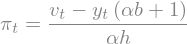

In [19]:
ad = sm.Eq(pi_t,1/(h*alpha)*(v_t-(1+b*alpha)*y_t))
ad

In [20]:
sras =sm.Eq(pi_t,pi_t1+gamma*y_t-phi*gamma*y_t1+s_t-phi*s_t1)
sras

We set the two equations equal to one another:

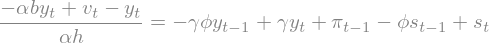

In [21]:
pi_from_ad = sm.solve(ad,pi_t)[0]
equilibrium_y = sras.subs(pi_t,pi_from_ad)
equilibrium_y

And solve for $y$ and $\pi$ : 

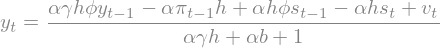

In [22]:
y_eq = sm.solve(equilibrium_y,y_t)[0]
y_equation = sm.Eq(y_t,y_eq)
# define as python function:
_y_equilibrium = sm.lambdify((y_t1,pi_t1,v_t,s_t,s_t1,alpha,gamma,h,b,phi),y_eq)

# print our solution symbolicaly 
y_equation

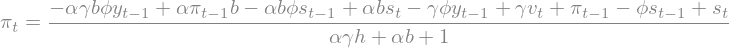

In [23]:
equilibrium_pi_equation = ad.subs(y_t,y_eq)
pi_equation = sm.Eq(pi_t,sm.solve(equilibrium_pi_equation,pi_t)[0])
# define as python function:
_pi_equilibrium = sm.lambdify((y_t1,pi_t1,v_t,s_t,s_t1,alpha,gamma,h,b,phi),sm.solve(equilibrium_pi_equation,pi_t)[0])
# print our solution symbolicaly 
pi_equation

If we insert phi=0 we get:

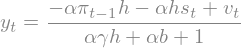

In [24]:
y_equation.subs(phi,0)

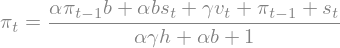

In [25]:
pi_equation.subs(phi,0)


**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

In [26]:
vars_0 = {}
for var in [y_t1,pi_t1,v_t,s_t,s_t1]:
    vars_0[var]=0
    
y_equation.subs(vars_0)

In [27]:
pi_equation.subs(vars_0)

Thus, when there are no shocks and no earlier output or inflation gab, there will also be no gabs in the following period

For $v_{t}=0.1$:

In [28]:
vars_0[v_t]=0.1

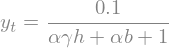

In [29]:
y_v1 = y_equation.subs(vars_0)
y_v1

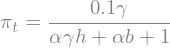

In [30]:
pi_v1 = pi_equation.subs(vars_0)
pi_v1

Both $y_{t}$ and $\pi_{t}$ is positvely afffected by demand_chocks in the current period.  

Then we substitute the parameter values, to see the outcome given our model and parameter values:

In [31]:
paras = {}
for var, value in zip([alpha,gamma,h,b],[par['alpha'],par['gamma'],par['h'],par['b']]):
    paras[var]=value
y_v1.subs(paras)

In [32]:
pi_v1.subs(paras)

In [33]:
sm.init_printing(use_unicode=False) 

In [34]:
# We redifine our lambdifyed funtion to accept the par-dictionairy, and check that they give the same result:
def y_equilibrium(y_t1,pi_t1,v_t,s_t,s_t1,par):
    '''
    Calculates the equilibrium outputgab using the analytical solution
    derived in sympy.
    
    Args:
        y_t1 (float)   : The outputgab in the previous period
        pi_t1 (float)  : The inflationgab in the previous period
        v_t (float)    : The demand chock in the current period
        s_t (float)    : The supply chock in the current period
        s_t1 (float)   : The supply chock in the previous period
        par (dict)     : Dictionairy contaning values of parameters.
    
    Returns:
        y_equil(float) : Equilibrium outputgab
    '''
    
    y_equil = _y_equilibrium(y_t1,pi_t1,v_t,s_t,s_t1,par['alpha'],par['gamma'],par['h'],par['b'],par['phi'])
    return y_equil

assert y_equilibrium(0,0,0,0,0,par)==0
y_equilibrium(0,0,0.1,0,0,par)

In [35]:
def pi_equilibrium(y_t1,pi_t1,v_t,s_t,s_t1,par):
    '''
    Calculates the equilibrium inflation gab using the analytical solution
    derived in sympy.
    
    Args:
        y_t1 (float)   : The outputgab in the previous period
        pi_t1 (float)  : The inflationgab in the previous period
        v_t (float)    : The demand chock in the current period
        s_t (float)    : The supply chock in the current period
        s_t1 (float)   : The supply chock in the previous period
        par (dict)     : Dictionairy contaning values of parameters.
    
    Returns:
        pi_equil(float) : Equilibrium inflation gab
    '''
        
    pi_equil = _pi_equilibrium(y_t1,pi_t1,v_t,s_t,s_t1,par['alpha'],par['gamma'],par['h'],par['b'],par['phi'])
    return pi_equil

assert pi_equilibrium(0,0,0,0,0,par)==0
pi_equilibrium(0,0,0.1,0,0,par)

Now we wish to visualize this, we start by plotting the AD and SRAS, with $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$:

In [36]:
def ad(y_t,v_t,par):
    '''
    Aggregate demand
    
    Args:
        y_t (float)   : Outputgab in current period
        v_t (float)   : Demand chock in current period
        par (dict)    : Dictionairy contaning values of parameters
    Returns 
        ad (float)    : Aggregate demand
    
    '''
    h = par['h']
    alpha =par['alpha']
    b = par['b']
    
    ad = 1/(h*alpha)*(v_t-(1+b*alpha)*y_t)
    return ad

def sras(y_t, y_t1,pi_t1,s_t,s_t1,par):
    '''
    Short run aggregate supply
    
    Args:
        y_t (float)   : Outputgab in current period
        y_t1 (float)  : The outputgab in the previous period
        pi_t1 (float) : The inflationgab in the previous period
        s_t (float)   : Supply chock in current period
        s_t1 (float)  : Supply chock in previous period
        par (dict)    : Dictionairy contaning values of parameters
    Returns 
        sras (float)  : Short run aggregate supply    
    '''
    
    phi = par['phi']
    gamma = par['gamma']
    sras = pi_t1+gamma*y_t-phi*gamma*y_t1+s_t-phi*s_t1
    return sras

In [37]:
# we find equilibrium path
t = 41
pis = [0,pi_equilibrium(0,0,0.1,0,0,par)]
ys = [0,y_equilibrium(0,0,0.1,0,0,par)]

for i in range(1,t):
    ys.append(y_equilibrium(ys[i],pis[i],0,0,0,par))
    pis.append(pi_equilibrium(ys[i],pis[i],0,0,0,par))

In [38]:
y_gabs = np.linspace(-0.005,0.03,100)
y_gabs = np.append(y_gabs,0)

In [39]:
# We find the ad-and sras curves: 
# period 0:
ads = [ad(y_gabs,0,par)]
srass = [sras(y_gabs,0,0,0,0,par)]
# append period 1:
ads.append(ad(y_gabs,0.1,par))
srass.append(sras(y_gabs,0,0,0,0,par))
#append period 2-40:
for i in range(2,t):
    ads.append(ad(y_gabs,0,par))
    srass.append(sras(y_gabs,ys[i],pis[i],0,0,par))


In [40]:
# Then we plot our results for period 0 and 1, and the equilibrium path:

p1 = Functions.plotting('Output gab',['AD','SRAS'],y_gabs[:-70],[ads[0][:-70],srass[0][:-70]],
                        'Inflation gab',legendlocation='top_right',title='AS-AD-model')

p2 = Functions.plotting('Output gab',['AD, v=0, period 0','SRAS','AD, v=0.1, period 1'],
                        y_gabs,[ads[0],srass[0],ads[1]],'Inflation gab',
                       legendlocation='top_right',title='AS-AD with demand chock')
p1.circle(x=[0],y=[0],legend='Equilibrium',line_width=3,color='red')
p2.circle(x=[0],y=[0],legend='Equilibrium in period 0',line_width=3,color='red')
p2.circle(x=[y_equilibrium(0,0,0.1,0,0,par)],y=[pi_equilibrium(0,0,0.1,0,0,par)],
          legend='Equilibrium in period 1',line_width=3,color='green')
p2.circle(x=ys,y=pis,legend='Path of Equilibrium',line_width=1,color='black')

show(row(p1,p2),notebook_handle=True)

In [41]:
# Then we plot everything interactively:
Functions.plotting_asad('Output gab',y_gabs,[srass,ads],'Inflation gab', 
                    legendlocation='bottom_right', width=500, height=500,
                    colors = ['blue',(226, 50, 86),'purple','green'], 
                    equilibrium_path=[ys,pis],keep_ad1 = True,line_width=3,
                   y_range=[-0.02,0.02],title='AS-AD with demand chock')

interactive(children=(IntSlider(value=0, description='period', max=39), Output()), _dom_classes=('widget-inter…

We see that inflation and output rises from the positive demand chock of $v_{1}=0.1$ in period 1, but in the following periods the inflationgab is still positive, but the outputgab becomes negative (boom-bust), afterwards we converge to the long term equilibrium.

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$


In [42]:
par['delta'] = 0.80
par['omega'] = 0.15

We define these new equations:

In [43]:
def demand_persistence(v_t1,x_t,par):
    '''
    Args:
        v_t1 (float)  : Demand chock in previous period
        x_t (float)   : Added demand chock in current period
    
    Returns:
        v_t (float)   : Demand chock in current period
    '''
    v_t = par['delta']*v_t1+x_t
    return v_t
def supply_persistence(s_t1,c_t,par):
    '''
    Args:
        s_t1 (float)  : Supply chock in previous period
        c_t (float)   : Added supply chock in current period
    
    Returns:
        s_t (float)   : Supply chock in current period
    '''
    s_t = par['omega']*s_t1+c_t
    return s_t

Period 0: <br>
We assume that $v_{-1}$ is also equal to 0, and we can calculate, with $x_{0}$=0.1:

In [44]:
v0 = demand_persistence(0,0.1,par)
y0 = y_equilibrium(0,0,v0,0,0,par)
pi0 = pi_equilibrium(0,0,v0,0,0,par)
print(f'Outputgab in period 0 is    {y0:.4f}')
print(f'Inflationgab in period 0 is {pi0:.4f}')

Outputgab in period 0 is    0.0244
Inflationgab in period 0 is 0.0018


In [45]:
v1 = demand_persistence(v0,0,par)
y1 = y_equilibrium(y0,pi0,v1,0,0,par)
pi1 = pi_equilibrium(y0,pi0,v1,0,0,par)
print(f'Outputgab in period 1 is    {y1:.4f}')
print(f'Inflationgab in period 1 is {pi1:.4f}')

Outputgab in period 1 is    0.0182
Inflationgab in period 1 is 0.0032


So initially $\pi$ and $y$ is positive, but we need to look at more periods to get the full picture:

Lets look at the development for 70 periods, first we find the equilibriums and plot them, then we look at how aggregate demand and supply:

In [46]:
T = 70
vs = [0,v0]
ys = [0,y0]
pis= [0,pi0]

for i in range(1,T):
    vs.append(demand_persistence(vs[i],0,par))
    ys.append(y_equilibrium(ys[i],pis[i],vs[i+1],0,0,par))
    pis.append(pi_equilibrium(ys[i],pis[i],vs[i+1],0,0,par))
    
zeros = [0 for i in range(-1,T)]

In [47]:
p1 = Functions.plotting('T',['Outputgab','Inflationgab',''],range(-1,T),
                        [[y*100 for y in ys],[pi*100 for pi in pis],zeros],
                        'Percentage gab from long run level',colors=['red','blue','black'],y_unit='%',
                       title='Progression of eqiulibrium after demand chock')
p2 = Functions.plotting('T',['Demand chock',''],range(-1,T),[vs,zeros],'',
                       colors = ['blue','black'],title='Autoregressive demand chock')
show(row(p1,p2),notebook_handle=True)

Now we plot the progression for the demand and supply curves

In [48]:
y_gabs = np.linspace(-0.02,0.05,100)

In [49]:
ad_curves = [ad(y_gabs,v,par) for v in vs]
sras_curves = [sras(y_gabs,0,0,0,0,par)]
for i in range(T+1):
    sras_curves.append(sras(y_gabs,ys[i],pis[i],0,0,par))

In [50]:
curve_names = ['SRAS, t=0,1','AD, t=0','AD, t=1','SRAS, t=2','AD, t=2',
               'SRAS, t=5','AD, t=5','SRAS, t=10','AD, t=10']
curves = [sras_curves[0],ad_curves[0],ad_curves[1],sras_curves[2],
          ad_curves[2],sras_curves[5],ad_curves[5],sras_curves[10],
         ad_curves[10]]

colors = [(0,0,153),(102,0,51),(153,0,76),(0,0,255),(204,0,102),(102,102,51),
         (255,102,178),(102,132,51),(255, 132, 208)]

p1 = Functions.plotting('Output gab',curve_names,y_gabs,curves,'Inflation gab',
                        legendlocation='top_right',width=600, height=600,
                        colors = colors, title ='AS-AD after demand chock')

p1.circle(x=ys,y=pis,legend='Path of equilibrium',color=(66, 244, 134))
p1.circle(x=ys[0],y=pis[0],line_width=3,color=(102,0,51))
p1.circle(x=ys[1],y=pis[1],line_width=3,color=(153,0,76))
p1.circle(x=ys[2],y=pis[2],line_width=3,color=(204,0,102))
p1.circle(x=ys[5],y=pis[5],line_width=3,color=(255,102,178))
p1.circle(x=ys[10],y=pis[10],line_width=3,color=(255,132,178))



show(p1,notebook_handle=True)

In [51]:
Functions.plotting_asad('Output gab',y_gabs,[sras_curves,ad_curves],
                    'Inflation gab', legendlocation='top_right',
                    width=600, height=600,line_width=2,
                    colors = ['blue',(226, 50, 86),(65, 134, 244),'green'], equilibrium_path=[ys,pis],
                   keep_ad1=True,title='AS-AD after demand chock')

interactive(children=(IntSlider(value=0, description='period', max=69), Output()), _dom_classes=('widget-inter…

We can see that the demand-curve jumps out in period 0, and slowly contract back to LR-AD, e.g. we can see the persistence of the initial demand chock. The SRAS on the other hand expands slowly, until around period 8, where it cotracts slowly towards SRAS

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

In [52]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2
t = 1000

Since the chocks in the model are stochastic and independent of the movements of the model (equilibrium etc.), we can compute and plot them before simulating the the model:

In [53]:
np.random.seed(1986)
xs = np.random.normal(0,par['sigma_x'],t)
cs = np.random.normal(0,par['sigma_c'],t)

In [54]:
vs = [demand_persistence(0,xs[0],par)]
ss = [supply_persistence(0,cs[0],par)]
for i in range(1,t):
    vs.append(demand_persistence(vs[i-1],xs[i],par))
    ss.append(supply_persistence(ss[i-1],cs[i],par))

In [55]:
p = Functions.plotting('T',['Demand chock','Supply chock'],range(t),[vs,ss],
                       'Chock',legendlocation='bottom_left',width=700,
                      title='Our simulated chocks',colors = ['blue','red'],line_width=1)
show(p,notebook_handle=True)

We can clearly see the higher standard deviation of the demand chocks.

Now we are ready to simulate the model:

In [56]:
def sim_asad(par,t=1000):
    '''
    Simulates the AS-AD model, with persistence stochastic chocks
    
    Args:
        par (dict)  : Dictionairy of parameter values
        t (int)     : Amount of periods simulated
    
    Returns:
        correlations (list): containing:
                                    Variance of outputgab
                                    Variance of inflationgab
                                    Correlations between output and inflation
                                    Autocorrelation of output 1 period back
                                    Autocorrelation of inflation 1 period back
        
        ys (list)   : The simulated outputgabs
        pis (list)  : The simulated inflation gbs
        
    
    '''
    
    np.random.seed(1986)
    xs = np.random.normal(0,par['sigma_x'],t)
    cs = np.random.normal(0,par['sigma_c'],t)
    
    vs = [demand_persistence(0,xs[0],par)]
    ss = [supply_persistence(0,cs[0],par)]
    
    ys = [y_equilibrium(0,0,vs[0],ss[0],0,par)]
    pis = [pi_equilibrium(0,0,vs[0],ss[0],0,par)]

    for i in range(1,t):
        vs.append(demand_persistence(vs[i-1],xs[i],par))
        ss.append(supply_persistence(ss[i-1],cs[i],par))
        ys.append(y_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
        pis.append(pi_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
    
    correlations = [np.var(ys),np.var(pis),np.corrcoef(ys,pis)[0,1],
             np.corrcoef(ys[:-1],ys[1:])[0,1],
             np.corrcoef(pis[:-1],pis[1:])[0,1]]
    return correlations,ys,pis
    

In [57]:
correlations,ys,pis = sim_asad(par)

In [58]:
p = Functions.plotting('T',['Inflation gab','Output gab'],range(t),[pis,ys],
                       'Percentage deviation',legendlocation='bottom_left',width=900,
                      title='Simulation of AS-AD-model',line_width=1)
show(p,notebook_handle=True)

In [59]:
data = [correlations]
df = pd.DataFrame(data, columns = [r'Var(\(y\))',r'Var(\(\pi\))',
                r'Corr(\(\pi,y\))',r'Corr(\(y_{t},y_{t-1}\))',r'Corr (\(\pi_{t},\pi_{t-1}\))    .'],index=['Value'])
df

,Var(\(y\)),Var(\(\pi\)),"Corr(\(\pi,y\))","Corr(\(y_{t},y_{t-1}\))","Corr (\(\pi_{t},\pi_{t-1}\)) ."
Value,1.995473,1.794619,-0.152624,0.780791,0.986923


We see a higher variance and loweer autocorrelation for outputgab than for the inflationgab, this could be due to the model having a relatively flat SRAS-curve causing our stronger (relative to supply-) demand chocks to mainly influence output. Furthermore the strong autocorrelation of $\pi$ could also come as a result of the parameter $\phi$ being set to zero, meaning that we assumed static inflation expectations. 

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

In [60]:
# Before this we save our original parametervalues
org_par = [par['phi'],par['sigma_x'],par['sigma_c']]

In [61]:
def corr_y_pi(par,t=t):
    ys = [y_equilibrium(0,0,vs[0],ss[0],0,par)]

    pis = [pi_equilibrium(0,0,vs[0],ss[0],0,par)]

    for i in range(1,t):
        ys.append(y_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
        pis.append(pi_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
    return np.corrcoef(ys,pis)[0,1]

In [62]:
corrs =[]
phis = np.linspace(0,1,500)
for phi in phis:
    par['phi']=phi
    corrs.append(corr_y_pi(par))

In [63]:
p = Functions.plotting('\u03C6',['Correlation between inflation- and outputgab'],phis,[corrs],
                       'Correlation Coefficient',legendlocation='top_left',width=900,
                      title='Correlation between inflation- and outputgab depended on \u03C6',line_width=1)
show(p,notebook_handle=True)

Now to find the $\phi$ that makes corr($\pi,y$)=0.31:

In [64]:
'''
An another way to find the right phi is to use an interpolater
but since the problem  explicityly says to use either an optimizeer
or a root_finder, we will also solve the problem using a rootfinder
'''
corr_interp = interpolate.interp1d(corrs,phis,kind='cubic')
phi_interperted = corr_interp([0.31])[0]

In [65]:
def obj1(phi):
    par['phi']=phi
    return corr_y_pi(par)-0.31
res = optimize.root_scalar(obj1,method='bisect',bracket=[0,1])
phi_optimized = res.root

In [66]:
assert np.isclose(phi_interperted,phi_optimized)

In [67]:
print('The phi that causes the correlation between the output- and inflationgab to be equal to 0.31 is:')
print(f'Phi = {phi_optimized}')

The phi that causes the correlation between the output- and inflationgab to be equal to 0.31 is:
Phi = 0.9640651869867725


**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

In [68]:
def obj2(paras,par=par,t=t):
    par['phi']=paras[0]
    par['sigma_x']=paras[1]
    par['sigma_c']=paras[2]
    
    corrs, ys, pis = sim_asad(par)
    roots = np.array(corrs) -np.array([1.64,0.21,0.31,0.84,0.48])
    return roots

In [69]:
res = optimize.root(obj2,[0.96,par['sigma_x'],par['sigma_c']],method='lm')
diff = res.fun
print(f'As close to zero as we can get with this optimizer: \n{diff}')
print(f'The values found was: \nPhi = {res.x[0]:.4f}, Sigma_x = {res.x[1]:.4f}, Sigma_c = {res.x[2]:.4f}')

As close to zero as we can get with this optimizer: 
[ 0.00524204 -0.15399737 -0.02923762 -0.02311971  0.00360194]
The values found was: 
Phi = 0.9679, Sigma_x = 2.9329, Sigma_c = 0.1880


In [70]:
par['phi']=res.x[0]
par['sigma_x']=res.x[1]
par['sigma_c']=res.x[2]
corrs, ys, pis = sim_asad(par)

In [71]:
for i in range(3):
    correlations.append(org_par[i])
    corrs.append(res.x[i])

data = [correlations,corrs,[1.64,0.21,0.31,0.84,0.48],list(diff),]
df = pd.DataFrame(data, columns = [r'Var(\(y\))',r'Var(\(\pi\))',
                r'Corr(\(\pi,y\))',r'Corr(\(y_{t},y_{t-1}\))',r'Corr (\(\pi_{t},\pi_{t-1}\))    .',
                r'\(\phi\)',r'\(\sigma_{x}\)',r'\(\sigma_{c}\)'],
                  index=['Original values','Imitated values','US-values','Difference'])

pd.set_option('display.max_colwidth', -1)
df

<ipython-input-71-b7dbf35c73be>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Var(\(y\)),Var(\(\pi\)),"Corr(\(\pi,y\))","Corr(\(y_{t},y_{t-1}\))","Corr (\(\pi_{t},\pi_{t-1}\)) .",\(\phi\),\(\sigma_{x}\),\(\sigma_{c}\)
Original values,1.995473,1.794619,-0.152624,0.780791,0.986923,0.000000,3.492000,0.200000
Imitated values,1.645242,0.056003,0.280762,0.816880,0.483602,0.967858,2.932851,0.187962
US-values,1.640000,0.210000,0.310000,0.840000,0.480000,NaN,NaN,NaN
Difference,0.005242,-0.153997,-0.029238,-0.023120,0.003602,NaN,NaN,NaN


# 3. Exchange economy
**Question 1:** Plot the histograms of the budget shares for each good across agents.

In [72]:
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.patches as mpatches 

In [73]:
plt.style.use('seaborn-pastel')

In [74]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1s = np.random.exponential(zeta,size=N)
e2s = np.random.exponential(zeta,size=N)
e3s = np.random.exponential(zeta,size=N)

In [75]:
#preparing data for histogram
hist1, edges1 = np.histogram(betas[:,0], bins=50)
hist2, edges2 = np.histogram(betas[:,1], bins=50)
hist3, edges3 = np.histogram(betas[:,2], bins=50)
colors = ['blue','green','red']
names =['Good 1','Good 2','Good 3']

#plotting
p = Functions.plot_hist([hist1,hist2,hist3], [edges1,edges2,edges3],
              line_colors= colors, fill_colors = colors,
             alpha = 0.5,plot_range=[0,1],names=names,x_label='\u03B2',
            y_label='Observations',title='Distribution of budgetshare')
show(p,notebook_handle=True)

**Question 2:** Plot the excess demand functions.

In [76]:
def income(p1,p2,p3,e1,e2,e3):
    I = p1*e1+p2*e2+p3*e3
    return I 

def demand_func(p1,p2,p3,e1,e2,e3,beta,good):
    '''
    Calculates the demand of a given good for a comsumer
    using the analytical solution
    
    Args:
        p1,p2,p3 (floats): Prices the consumer is faced with
        e1,e2,e3 (floats): Endowments of the consumer
        beta (float)     : Share of budget that the consumer wishes to spend on the good
        good (int)       : Either 1,2 or 3, indicating which good we are looking at
        
    Returns:
        demand (float)   : Amount of the good that the consumer wishes to consume given constraints
    
    '''
    I = income(p1,p2,p3,e1,e2,e3)
    if good==1:
        demand = beta*I/p1
    elif good==2:
        demand = beta*I/p2
    elif good==3:
        demand = beta*I/p3
    else:
        print('Error, we only have three goods')
        
    return demand

def excess_demand_good_func(p1,p2,p3,e1s,e2s,e3s,betas,good):
    '''
    Calculates the total excess demand in the market for a given good.
    
    Args:
        p1,p2,p3 (floats)     : Prices the consumers are faced with
        e1s,e2s,e3s (arrays)  : Endowments of all consumers for each good
        betas (array)         : Shares of budget that the consumers wishes to spend on each good
        good (int)            : Either 1,2 or 3, indicating which good we are looking at
        
    Returns:
        Excees_demand (float) : The excess demand in the market for the good given the prices.
    
    '''
    
    beta = betas[:,good-1]
    
    
    demand = np.sum(demand_func(p1,p2,p3,e1s,e2s,e3s,beta,good=good))
    
    
    if good==1:
        supply = np.sum(e1s)
    elif good==2:
        supply = np.sum(e2s)
    else:
        supply = np.sum(e3s)
    
    
    excess_demand = demand-supply
    
    return excess_demand

In [77]:
precision  = 60
# Setting p3 numeria 
p3 = 1
p1_space = np.linspace(2,7,precision)
p2_space = np.linspace(2,7,precision)
p1s,p2s = np.meshgrid(p1_space,p2_space,indexing='ij')
excess_demands = [np.empty((precision,precision)),np.empty((precision,precision)),np.empty((precision,precision))]

In [78]:
for k in range(3):
    for i in range(precision):
        for j in range(precision):
            excess_demands[k][i,j]=excess_demand_good_func(p1s[i,j],p2s[i,j],p3,e1s,e2s,e3s,betas,good=(k+1))

In [79]:
%matplotlib widget
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1,projection='3d') 
ax.plot_surface(p1s,p2s,excess_demands[0],cmap=cm.jet)
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('Excess demand of good 1')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Excess demand of good 1')

In [80]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1,projection='3d') 
ax.plot_surface(p1s,p2s,excess_demands[1],alpha=1,cmap=cm.jet)
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('Excess demand of good 2')
ax.invert_yaxis()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [81]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1,projection='3d') 

ax.plot_surface(p1s,p2s,excess_demands[2],alpha=1,cmap=cm.jet)
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('Excess demand of good 3')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Excess demand of good 3')

In [82]:
%matplotlib inline

**Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [83]:
def find_equilibrium(p1, p2, p3, e1s, e2s, e3s, betas, kappa=0.5, eps=0.1, maxiter=5000):
    '''
    Finds the Walras eqilibrium prices, which clears the markets for good 1 and 2, 
    implictly also clearing the market for good 3 
    
    Args:
        p1,p2,p3 (floats)     : Prices the consumers are faced with
        e1s,e2s,e3s (arrays)  : Endowments of all consumers for each good
        betas (array)         : Shares of budget that the consumers wishes to spend on each good
        kappa (float)         : Aggressivity parameter
        epsilon (float)       : Tolerance
        maxiter (int)         : Maximum number of iterations to calculate
        
    Returns:
        p1,p2 (floats)        : Walras eqiulibrium prices
    
    '''
    
    
    t = 0
    while True: 
        Z1 = excess_demand_good_func(p1,p2,p3,e1s,e2s,e3s, betas, 1)
        Z2 = excess_demand_good_func(p1,p2,p3,e1s,e2s,e3s, betas, 2)
        
        
        if (np.abs(Z1) < eps and np.abs(Z2)<eps) or t >= maxiter:
            print(f'Step {t:3d}:')
            print(f'p1 = {p1:12.8f} -> excess demand 1 -> {Z1:14.8f}')
            print(f'p2 = {p2:12.8f} -> excess demand 2 -> {Z2:14.8f}')
            Z3 = excess_demand_good_func(p1,p2,p3,e1s,e2s,e3s, betas, 3)
            print(f'Also --------------> excess demand 3 -> {Z3:14.8f}')
            break

        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N         
        if t < 5 or t%2500 == 0:
            print(f'Step {t:3d}:')      
            print(f'p1 = {p1:12.8f} -> excess demand 1-> {Z1:14.8f}')
            print(f'p2 = {p2:12.8f} -> excess demand 2-> {Z2:14.8f}')
                   
        elif t == 5:
            print("  ...")
        t += 1
    return p1, p2


In [84]:
kappa = 0.1
eps = 0.000001
maxiter = 50000
p3 = 1
p2 =1
p1 = 1
p1,p2 = find_equilibrium(p1, p2, p3, e1s, e2s, e3s,betas, kappa=kappa, eps=eps, maxiter=maxiter)

Step   0:
p1 =   1.09260612 -> excess demand 1-> 46303.06210182
p2 =   0.97796409 -> excess demand 2-> -11017.95327569
Step   1:
p1 =   1.17305159 -> excess demand 1-> 40222.73067623
p2 =   0.95953050 -> excess demand 2-> -9216.79648110
Step   2:
p1 =   1.24453025 -> excess demand 1-> 35739.33136121
p2 =   0.94431730 -> excess demand 2-> -7606.59981301
Step   3:
p1 =   1.30907401 -> excess demand 1-> 32271.87934840
p2 =   0.93199522 -> excess demand 2-> -6161.04112688
Step   4:
p1 =   1.36807540 -> excess demand 1-> 29500.69778865
p2 =   0.92226760 -> excess demand 2-> -4863.80959762
  ...
Step 2500:
p1 =   6.46564122 -> excess demand 1->    22.41209085
p2 =   2.60758603 -> excess demand 2->     8.36130845
Step 5000:
p1 =   6.48980287 -> excess demand 1->     0.23073526
p2 =   2.61659989 -> excess demand 2->     0.08607759
Step 7500:
p1 =   6.49005253 -> excess demand 1->     0.00239291
p2 =   2.61669302 -> excess demand 2->     0.00089269
Step 10000:
p1 =   6.49005512 -> excess demand

Now we wish to plot our optimal prices with the excess demands for all goods

In [85]:
precision  = 60
p3 = 1
p1_space = np.linspace(6,7,precision)
p2_space = np.linspace(2,3,precision)
p1s,p2s = np.meshgrid(p1_space,p2_space,indexing='ij')
excess_demands = [np.empty((precision,precision)),np.empty((precision,precision)),np.empty((precision,precision))]

In [86]:
for k in range(3):
    for i in range(precision):
        for j in range(precision):
            excess_demands[k][i,j]=excess_demand_good_func(p1s[i,j],p2s[i,j],p3,e1s,e2s,e3s,betas,good=(k+1))

In [87]:
%matplotlib widget
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1,projection='3d') 
ax.plot_surface(p1s,p2s,excess_demands[0],alpha=0.8)
ax.plot_surface(p1s,p2s,excess_demands[1],alpha=0.8)
ax.plot_surface(p1s,p2s,excess_demands[2],alpha=0.8,cmap='Purples')
p1_vec= [p1 for i in range(20000)]
p2_vec = [p2 for i in range(20000)]
z = np.linspace(-2500,12000,20000)
ax.plot(p1_vec,p2_vec,z,color='red',linewidth=3)
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('Excess demand')
ax.invert_xaxis()


labels = [mpatches.Patch(color='blue',label='Good 1')]
labels.append(mpatches.Patch(color='green',label='Good 2'))
labels.append(mpatches.Patch(color='purple',label='Good 3'))
labels.append(mpatches.Patch(color='red',label='Walras equilibrium prices'))

ax.legend(handles=labels,loc='upper left',prop={'size':10})


#Set initial view:
ax.view_init(elev=10, azim=-30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
%matplotlib inline

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [89]:
x1s = demand_func(p1,p2,p3,e1s,e2s,e3s,betas[:,0],1)
x2s = demand_func(p1,p2,p3,e1s,e2s,e3s,betas[:,1],2)
x3s = demand_func(p1,p2,p3,e1s,e2s,e3s,betas[:,2],3)

betas[:,1]


def utility(x1,x2,x3,beta1,beta2,beta3, gamma):
    utility = (x1**beta1*x2**beta2*x3**beta3)**gamma
    return utility

utilitys = []
for i in range(N):
    utilitys.append(utility(x1s[i],x2s[i],x3s[i],betas[i,0],betas[i,1],betas[i,2], gamma))

In [90]:
hist, edges = np.histogram(utilitys, bins=100)
plot1 = Functions.plot_hist([hist], [edges],names= [''],plot_range=[0,4],
                       y_label='Observations',x_label='Utility')
mean = np.mean(utilitys)
variance = np.var(utilitys)

meantext = Label(x=290, y=370, text=f'Mean       = {mean:.3f}',
              text_font_size='10pt',x_units='screen', y_units='screen')
vartext = Label(x=290, y=355, text=f'Variance  = {variance:.3f}',
              text_font_size='10pt',x_units='screen', y_units='screen')
plot1.add_layout(meantext)
plot1.add_layout(vartext)
               
show(plot1,notebook_handle=True)

We can see that the distriubtion is right skewed with a mean close to 1, indicating that the average comsumer is not much better of, given random distribution of endowments and free trade oportunities, than if all endowments was distributed equally and no trade was allowed, so all consumers consumed precisly one of each good, giving a utility of one independent of parameter-preferences. 

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

First we find a plot the new distriubtion with still kepping $\gamma=0.8$

In [91]:
e = np.full(N,1)
p1_equal,p2_equal = find_equilibrium(p1, p2, p3, e, e, e, betas,kappa=kappa, eps=eps, maxiter=maxiter)

Step   0:
p1 =   6.49007569 -> excess demand 1->    10.27306936
p2 =   2.61638187 -> excess demand 2->  -156.06712716
Step   1:
p1 =   6.49009303 -> excess demand 1->     8.67191455
p2 =   2.61607875 -> excess demand 2->  -151.55895838
Step   2:
p1 =   6.49010728 -> excess demand 1->     7.12421295
p2 =   2.61578436 -> excess demand 2->  -147.19285237
Step   3:
p1 =   6.49011854 -> excess demand 1->     5.62826125
p2 =   2.61549843 -> excess demand 2->  -142.96436254
Step   4:
p1 =   6.49012690 -> excess demand 1->     4.18240975
p2 =   2.61522070 -> excess demand 2->  -138.86917806
  ...
Step 2500:
p1 =   6.44778466 -> excess demand 1->    -0.42306241
p2 =   2.59099067 -> excess demand 2->    -0.15730786
Step 5000:
p1 =   6.44733119 -> excess demand 1->    -0.00419167
p2 =   2.59082205 -> excess demand 2->    -0.00155860
Step 7500:
p1 =   6.44732670 -> excess demand 1->    -0.00004153
p2 =   2.59082038 -> excess demand 2->    -0.00001544
Step 9519:
p1 =   6.44732665 -> excess demand 1

Thus, the price of good 1 slightly drops, while the price of good 2 slightly rises.

In [92]:
x1s_equal = demand_func(p1_equal,p2_equal,p3,e,e,e,betas[:,0],1)
x2s_equal = demand_func(p1_equal,p2_equal,p3,e,e,e,betas[:,1],2)
x3s_equal = demand_func(p1_equal,p2_equal,p3,e,e,e,betas[:,2],3)


utilitys_equal = []
for i in range(N):
    utilitys_equal.append(utility(x1s_equal[i],x2s_equal[i],x3s_equal[i],betas[i,0],betas[i,1],betas[i,2], 0.9))

    
hist, edges = np.histogram(utilitys_equal, bins=100)
plot2 = Functions.plot_hist([hist], [edges],names= [''],plot_range=[0,4],
                       y_label='Observations',x_label='Utility')
mean = np.mean(utilitys_equal)
variance = np.var(utilitys_equal)

meantext = Label(x=290, y=370, text=f'Mean       = {mean:.3f}',
              text_font_size='10pt',x_units='screen', y_units='screen')
vartext = Label(x=290, y=355, text=f'Variance  = {variance:.3f}',
              text_font_size='10pt',x_units='screen', y_units='screen')
plot2.add_layout(meantext)
plot2.add_layout(vartext)
               
show(plot2,notebook_handle=True)

We have a sligthly bigger mean, and a much lower variance, with the endowemnts having been distributed equally. <br>
With everyone starting out with one of each good, all comsumers have a minimum utility of 1, and much less trade seems to be occuring.

Now we plot the same figures, both for different values of $\gamma$:

In [93]:
gammas = [0.2,0.4,0.6,0.8,1,1.5]

plots =[]

for i,gamma in enumerate(gammas):
    plots.append(Functions.utility_distribution(x1s,x2s,x3s,x1s_equal,x2s_equal,x3s_equal,betas,gamma))

In [94]:
show(column(row(plots[0][0],plots[0][1]),row(plots[1][0],plots[1][1]),row(plots[2][0],plots[2][1]),
           row(plots[3][0],plots[3][1]),row(plots[4][0],plots[4][1]),row(plots[5][0],plots[5][1])))

We see that the variance rises with gamma for both random and equally distributed endowments. The mean also mostly rises, but not for small $\gamma$ with randomly distributed endowments where we see that it drops. <br>
We have to note though, that this is only the distriubtion of utility function for the level of comsumption for each consumer. Changing gamma does not affect the prices nor the distribution of comsumption, only the value of the utility function.